# Numerical solution of the Puasson equation

In [214]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import copy

In [433]:
a = 0
b = 1
c = 0
d = 1

def u(x1, x2):
    return np.cos(x1 * x2)

def f(x1, x2):
    return -(x1 ** 2 + x2 ** 2) * np.cos(x1 * x2)

def mu1(x2):
    return 1

def mu2(x2):
    return -x2 * np.sin(x2)

def mu3(x1):
    return 1

def mu4(x1):
    return np.cos(x1)

In [434]:
def plot_graphs(x, t, u, y):
    T, X = np.meshgrid(t, x)
    
    fig = plt.figure()
    plt.figure(figsize=(12, 8))
    
    ax = plt.axes(projection='3d')
    ax.contour3D(X, T, u, 250, cmap='Greens')
    ax.contour3D(X, T, y, linewidths=3, cmap='Oranges')
    ax.set_xlabel('x')
    ax.set_ylabel('t')
    ax.set_zlabel('u/y')
    plt.show()

In [468]:
def difference_scheme(a, b, c, d, f, h1, h2, eps, method):
    N1 = round((b - a) / h1)
    N2 = round((d - c) / h2)
    x1 = [h1 * i for i in range(N1 + 1)]
    x2 = [h2 * j for j in range(N2 + 1)]
    
    y = np.zeros((N1 + 1, N2 + 1))
    for i in range(N1 + 1):
        y[i][0] = mu3(x1[i])
        y[i][N2] = mu4(x1[i])
    for j in range(N2 + 1):
        y[0][j] = mu1(x2[j])
        
    y, k = method(y, N1, N2, h1, h2, x1, x2, eps)
    return x1, x2, y, k


def mpi(y, N1, N2, h1, h2, x1, x2, eps):
    k = 0
    while True:
        err = 0
        y_prev = copy.deepcopy(y)
        for j in range(1, N2):
            for i in range(1, N1):
                y[i][j] = h1 ** 2 * h2 ** 2 / (2 * h1 ** 2 + 2 * h2 ** 2) * ((y_prev[i + 1][j] + y_prev[i - 1][j]) / h1 ** 2 + (y_prev[i][j + 1] + y_prev[i][j - 1]) / h2 ** 2 - f(x1[i], x2[j]))
                err = max(err, abs(y[i][j] - y_prev[i][j]))
            y[N1][j] = h2 ** 2 / (h1 ** 2 + h2 ** 2) * (y_prev[N1 - 1][j] + h1 * (mu2(x2[j]) + h1 / 2 * ((y_prev[N1][j + 1] + y_prev[N1][j - 1]) / h2 ** 2 - f(x1[N1], x2[j]))))
            err = max(err, abs(y[N1][j] - y_prev[N1][j]))
        k += 1
        if err <= eps:
            break
    return y, k


def zeidel(y, N1, N2, h1, h2, x1, x2, eps):
    k = 0
    while True:
        err = 0
        for j in range(1, N2):
            for i in range(1, N1):
                y_prev = y[i][j]
                y[i][j] = h1 ** 2 * h2 ** 2 / (2 * h1 ** 2 + 2 * h2 ** 2) * ((y[i + 1][j] + y[i - 1][j]) / h1 ** 2 + (y[i][j + 1] + y[i][j - 1]) / h2 ** 2 - f(x1[i], x2[j]))
                err = max(err, abs(y[i][j] - y_prev))
            y_N1_prev = y[N1][j]
            y[N1][j] = h2 ** 2 / (h1 ** 2 + h2 ** 2) * (y[N1 - 1][j] + h1 * (mu2(x2[j]) + h1 / 2 * ((y[N1][j + 1] + y[N1][j - 1]) / h2 ** 2 - f(x1[N1], x2[j]))))
            err = max(err, abs(y[N1][j] - y_N1_prev))
        k += 1
        if err <= eps:
            break
    return y, k

### MPI

In [475]:
h1 = 0.1
h2 = 0.1
eps = 10 ** -6

In [469]:
x1, x2, y, k = difference_scheme(a, b, c, d, f, h1, h2, eps, mpi)

u_values = [[u(x1i, x2i) for x2i in x2] for x1i in x1]
print(np.abs(np.subtract(u_values, y)).max())

0.00010131263178914107


In [470]:
k

347

<Figure size 640x480 with 0 Axes>

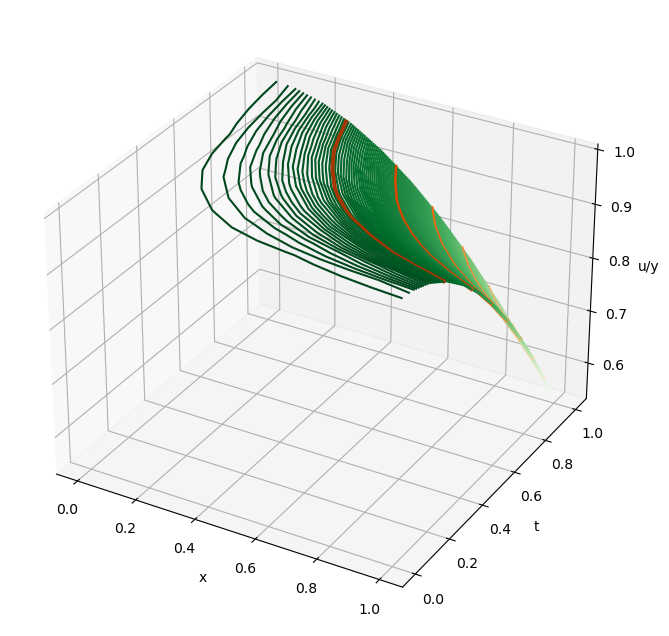

In [471]:
plot_graphs(x1, x2, u_values, y)

### Zeidel

In [476]:
h1 = 0.1
h2 = 0.1
eps = 10 ** -6

In [472]:
x1, x2, y, k = difference_scheme(a, b, c, d, f, h1, h2, eps, zeidel)

u_values = [[u(x1i, x2i) for x2i in x2] for x1i in x1]
print(np.abs(np.subtract(u_values, y)).max())

9.115453255226225e-05


In [473]:
k

183

<Figure size 640x480 with 0 Axes>

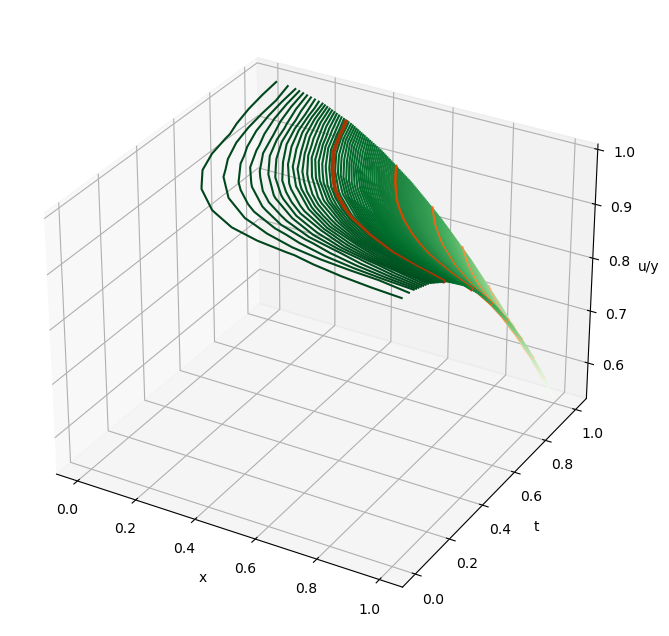

In [474]:
plot_graphs(x1, x2, u_values, y)